In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

In [3]:
df = pd.read_excel('premiums_young.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [4]:
df.shape

(20096, 13)

In [5]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [6]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [7]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


### Handling NA values

In [8]:
# Checking for NA values
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [9]:
# dropping rows with na feature values
df.dropna(inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [12]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [13]:
# Showing all the negative values from number_of_dependants column
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [14]:
# making negative values of number_of_dependants positive
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [15]:
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

### Data Visualization

In [16]:
# Filtering out all the numeric columns
num_columns = df.select_dtypes(['float64', 'int64']).columns

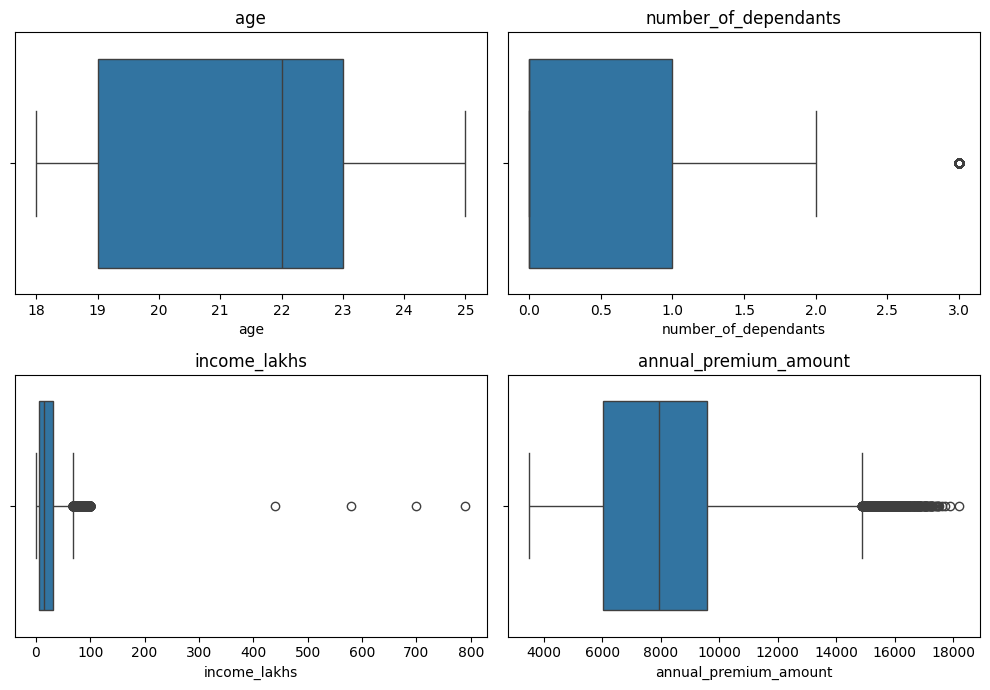

In [17]:
# Plotting box plot
plt.figure(figsize=(10, 7))

for i, column in enumerate(num_columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [18]:
# Analyzing the outliers of age column
df[df['age']>100]['age'].unique()

array([], dtype=int64)

In [19]:
df1 = df[df['age']<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [20]:
# Analyzing the outliers for 'income_lakhs' feature
# using quantile to set a reasonable threshold

income_quantile_threshold = df1.income_lakhs.quantile(0.999).copy()
print('income quantile threshold is:',income_quantile_threshold)

df2 = df1[df1.income_lakhs<=income_quantile_threshold].copy()
df2.income_lakhs.describe()

income quantile threshold is: 100.0


count    20086.000000
mean        22.390371
std         21.732062
min          1.000000
25%          6.000000
50%         16.000000
75%         31.000000
max        100.000000
Name: income_lakhs, dtype: float64

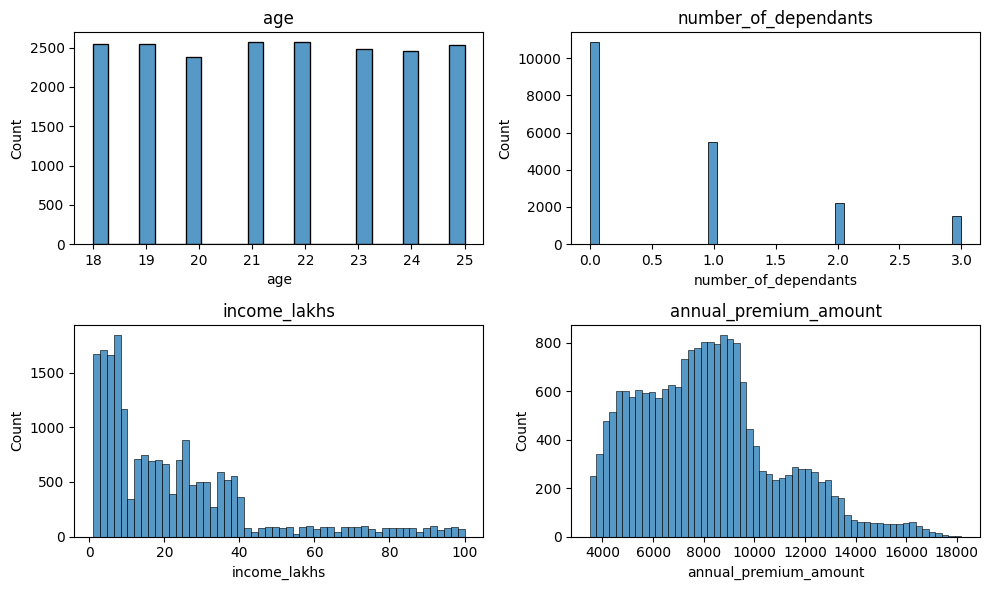

In [21]:
# Data Visualization

plt.figure(figsize=(10, 6))

for i, col in enumerate(num_columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df2[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [22]:
categorical_columns = ['income_level', 'employment_status', 'smoking_status', 'bmi_category', 'marital_status', 'gender', 'region', 'medical_history', 'insurance_plan']

for col in categorical_columns:
    print(col, df2[col].unique())

# Something fishy in smoking_status feature

income_level ['> 40L' '<10L' '10L - 25L' '25L - 40L']
employment_status ['Self-Employed' 'Freelancer' 'Salaried']
smoking_status ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
bmi_category ['Overweight' 'Underweight' 'Normal' 'Obesity']
marital_status ['Unmarried' 'Married']
gender ['Male' 'Female']
region ['Northeast' 'Northwest' 'Southeast' 'Southwest']
medical_history ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan ['Silver' 'Bronze' 'Gold']


In [23]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
})

df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional', 'Smoking=0',
       'Does Not Smoke', 'Not Smoking'], dtype=object)

In [24]:
gender_percentage = df2['gender'].value_counts(normalize=True)
gender_percentage

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

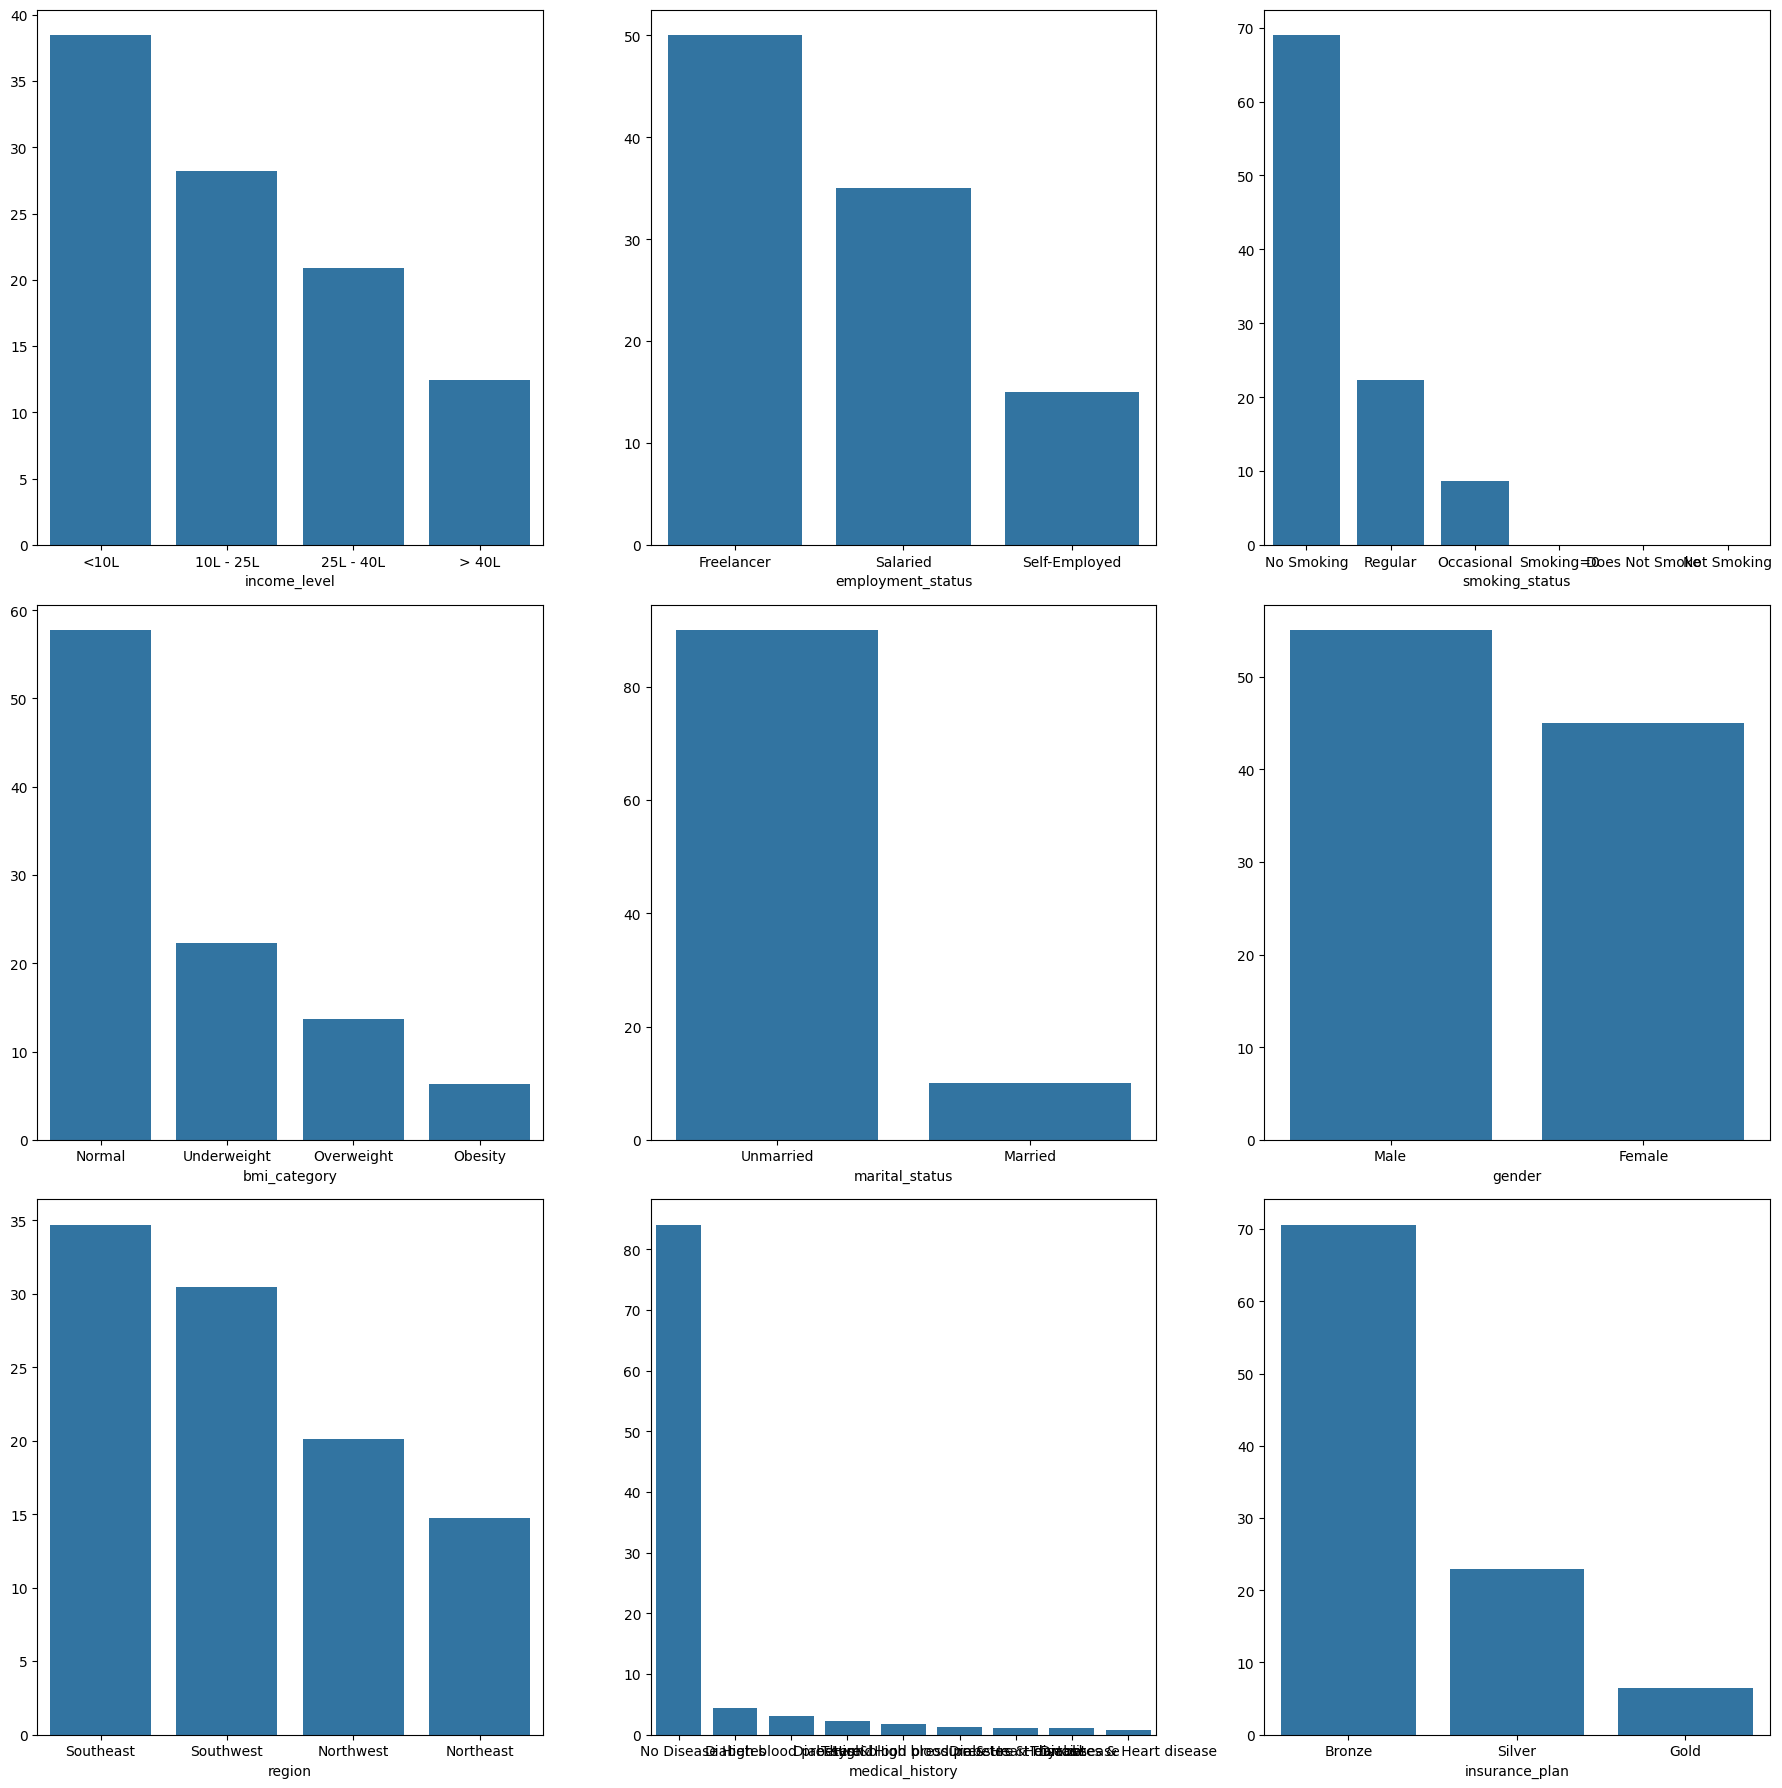

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()
for axx, column in zip(axes, categorical_columns):

    category_counts = df2[column].value_counts(normalize=True) * 100
    
    sns.barplot(x = category_counts.index, y = category_counts.values, ax=axx)

plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              116   366    2026


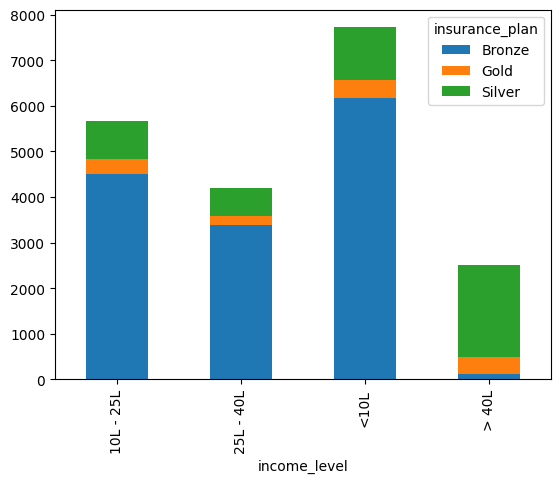

In [26]:
# For bivariate analysis
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True);

## Feature Engineering

In [27]:
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [28]:
# Let's create a column 'risk_score' for rating the risk according to existing diseases

risk_scores={
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

In [29]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())

In [30]:
df2['disease2'] = df2['disease2'].fillna('none')

In [31]:
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# normalizing the risk scores
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

df2['normalized_risk_score'] = (df2['total_risk_score']-min_score)/(max_score-min_score)

df2['total_risk_score']
df2['disease1'].unique(), df2['disease2'].unique()

(array(['high blood pressure', 'no disease', 'diabetes', 'heart disease',
        'thyroid'], dtype=object),
 array(['none', 'high blood pressure', 'heart disease', 'thyroid'],
       dtype=object))

In [32]:
# Label encoding for insurance_plan and income level

df2['insurance_plan'] = df2.insurance_plan.map({'Bronze':1, 'Silver':2, 'Gold':3})

df2['income_level'] = df2.income_level.map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})

In [33]:
# Doing one hot encoding for nominal columns

nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)

df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_No Smoking,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,smoking_status_Smoking=0,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,1,0,0,0,0,1,0,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,1,0,0,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,0,0,0,0,0,0,1,0,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,0,0,0,1,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,0,1,0,1,0,0,0,0,0,0


In [34]:
# Dropping unnecessary columns

df4 = df3.drop(['disease1', 'disease2', 'medical_history', 'total_risk_score'], axis=1)
df4

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,...,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_No Smoking,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,smoking_status_Smoking=0,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,...,0,1,0,0,0,0,1,0,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,...,0,0,1,1,0,0,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,...,0,0,0,0,0,0,1,0,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20091,18,0,4,91,3,11603,0.000000,0,0,1,...,0,0,1,1,0,0,0,0,0,0
20092,23,0,4,57,3,14498,0.428571,0,1,0,...,1,0,0,0,0,1,0,0,0,0
20093,24,0,3,35,1,9111,0.000000,0,1,0,...,0,0,1,1,0,0,0,0,0,1
20094,21,0,3,32,1,8564,0.000000,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [35]:
scaler = MinMaxScaler()

X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,...,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_No Smoking,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,smoking_status_Smoking=0,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,...,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,...,0.063527,0.136513,0.222493,0.689535,0.000100,0.086379,0.223589,0.000249,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,...,0.243914,0.343341,0.415931,0.462696,0.009978,0.280929,0.416660,0.015776,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
# 'income_level' and 'income_lakhs' seems to have higher VIF, we can drop those columns

X_refined = X.drop(['income_level'], axis=1)
X_refined.shape, y.shape
X_refined.drop(['smoking_status_Smoking=0','smoking_status_Not Smoking','smoking_status_No Smoking'], axis=1, inplace=True)
X_refined.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

## Model Training and Fine Tuning

In [37]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_refined, y, test_size=0.3, random_state=42)
print('X_train', X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test', y_test.shape)


X_train (14060, 17)
X_test (6026, 17)
y_train (14060,)
y_test (6026,)


### Training Linear Regression Model

In [38]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
print('linear regression model testing data prediction',linear_reg_model.score(X_test, y_test)) # 100% !!!!!!!! LOL
print('linear regression model training data prediction',linear_reg_model.score(X_train, y_train))
y_pred_linear = linear_reg_model.predict(X_test)
print('mse:',mean_squared_error(y_test, y_pred_linear))


linear regression model testing data prediction 0.6006143379050812
linear regression model training data prediction 0.6038233962462742
mse: 3042911.242917955


### Analysis of coefficients

In [39]:
linear_reg_model.coef_, linear_reg_model.feature_names_in_

(array([ 2.36884148e+01, -2.81603858e+01,  6.06515998e+01,  6.97000722e+03,
         1.14617372e+03,  2.27709031e+00, -8.85129128e+01, -2.63407586e+00,
         4.00535339e-01,  3.11161583e+00,  8.48014989e+02,  3.85748545e+02,
         1.86980641e+02,  2.89716954e+02,  6.32388157e+02,  7.72265002e+00,
         2.18415123e+01]),
 array(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
        'normalized_risk_score', 'gender_Male', 'region_Northwest',
        'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
        'bmi_category_Obesity', 'bmi_category_Overweight',
        'bmi_category_Underweight', 'smoking_status_Occasional',
        'smoking_status_Regular', 'employment_status_Salaried',
        'employment_status_Self-Employed'], dtype=object))

<BarContainer object of 17 artists>

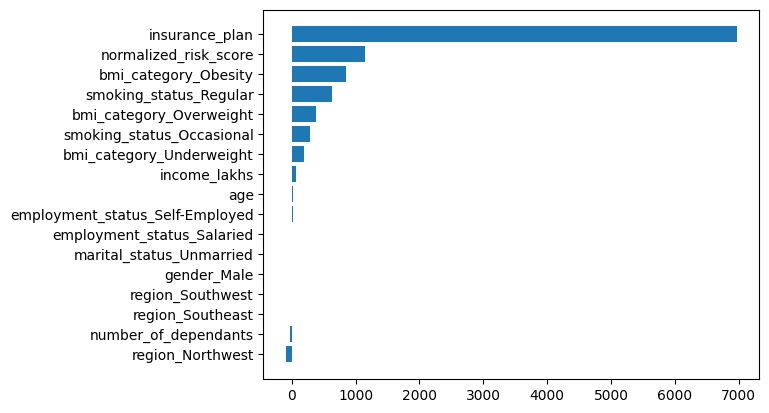

In [40]:
coef_df = pd.DataFrame({
    'columns': X_train.columns,
    'Coefficients':linear_reg_model.coef_
})

coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

plt.barh(coef_df['columns'], coef_df['Coefficients']) # insurance plan will have more impact on the predictions

### Training Ridge Regressor Model

In [41]:
ridge_model = Ridge(alpha=8)
ridge_model.fit(X_train, y_train)
print('ridge score on testing data:', ridge_model.score(X_test, y_test))
print('ridge score on training data:', ridge_model.score(X_train, y_train))

ridge score on testing data: 0.6006157682946196
ridge score on training data: 0.6037947441974958


#### Training XGBoost Model

In [42]:
xgb_model = XGBRegressor(n_estimators=20, max_depth=3)
xgb_model.fit(X_train, y_train)
print('xgb model score for testing data:',xgb_model.score(X_test, y_test))
print('xgb model score for training data:',xgb_model.score(X_train, y_train))

xgb model score for testing data: 0.5997341871261597
xgb model score for training data: 0.607659101486206


#### Calculating MSE and RMSE for XGBoost model

In [43]:
y_pred_xgb = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
print('this is xgboost mse: ', mse, 'and this is rmse for xgboost',rmse)

this is xgboost mse:  3049617.0 and this is rmse for xgboost 1746.3152636336888


#### Using randomized search cv for getting the best parameters and best model

In [44]:
xgb_model_regressor = XGBRegressor()
#Parameters Grid
param_selection_grid={
    'n_estimators':[20, 40, 50],
    'learning_rate':[0.1, 0.2, 0.3],
    'max_depth':[3, 4, 5]
}

random_search = RandomizedSearchCV(xgb_model_regressor, param_selection_grid, n_iter=3, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('randomized search best score: ', random_search.best_score_)
print('best estimator is:', best_model)
print('best params are:', random_search.best_params_)

randomized search best score:  0.6004706025123596
best estimator is: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=20,
             n_jobs=None, num_parallel_tree=None, ...)
best params are: {'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.2}


#### Plotting bar graph and analyzing coefficients for XGBoost Model

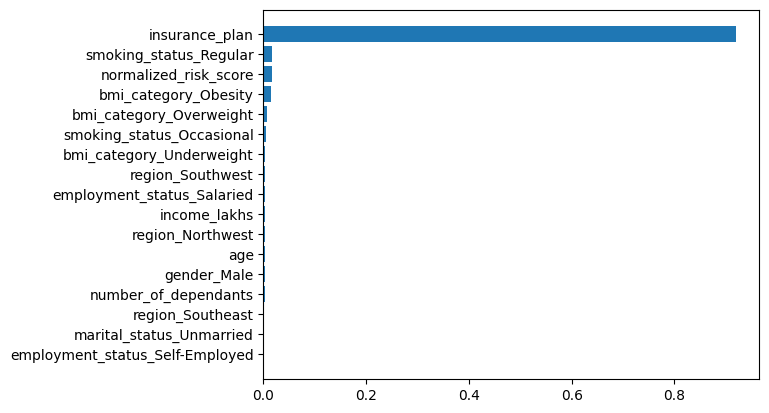

In [45]:
coef_df = pd.DataFrame({
    'columns': X_train.columns,
    'Coefficients':xgb_model.feature_importances_
})
# Tree based models use feature_importances, linear model uses coef_

coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

plt.barh(coef_df['columns'], coef_df['Coefficients']);

### Error Analysis

In [46]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residual_percentage = (residuals/y_test)*100

error_results = pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'residual':residuals,
    'residual_percentage':residual_percentage
})

error_results.head()

,actual,predicted,residual,residual_percentage
10489,5452,6943.396973,1491.396973,27.355044
7989,9658,7592.335938,-2065.664062,-21.388114
3113,6031,8294.240234,2263.240234,37.526782
10605,12386,10451.588867,-1934.411133,-15.617723
4204,4245,7131.442383,2886.442383,67.996287


<AxesSubplot: xlabel='residual_percentage', ylabel='Count'>

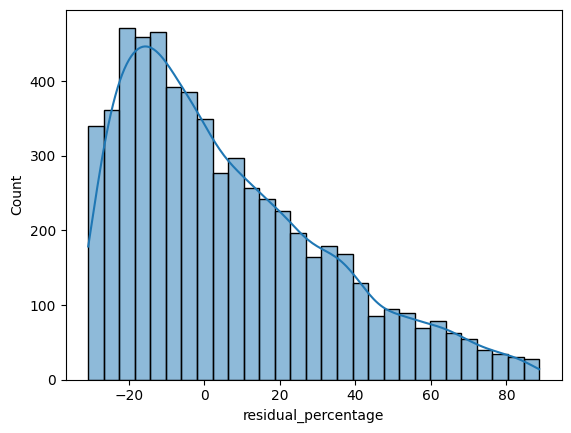

In [47]:
sns.histplot(error_results['residual_percentage'], kde=True)

In [48]:
extreme_error_results = error_results[np.abs(error_results.residual_percentage)>10]

print('percentage of error more than 10%', extreme_error_results.shape[0]*100/error_results.shape[0])

extreme_error_results.head()

percentage of error more than 10% 72.43611018918021


,actual,predicted,residual,residual_percentage
10489,5452,6943.396973,1491.396973,27.355044
7989,9658,7592.335938,-2065.664062,-21.388114
3113,6031,8294.240234,2263.240234,37.526782
10605,12386,10451.588867,-1934.411133,-15.617723
4204,4245,7131.442383,2886.442383,67.996287


In [49]:
X_test.index

Index([10489,  7989,  3113, 10605,  4204, 16419,  6534,  1712, 15712, 10360,
       ...
       12378,  2039,  1023,  8235, 18542, 18960,   266, 10036, 15506, 10890],
      dtype='int64', length=6026)

In [50]:
extreme_error_results.index # these are the rows in X_test which has high margin errors

Index([10489,  7989,  3113, 10605,  4204, 16419,  6534,  1712, 10360, 18164,
       ...
        6215, 17331, 12378,  1023,  8235, 18542, 18960,   266, 10036, 10890],
      dtype='int64', length=4365)

In [51]:
X_test.loc[extreme_error_results.index].shape

(4365, 17)

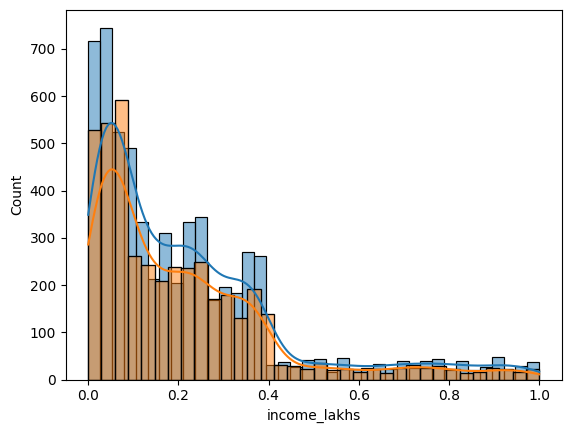

In [52]:
extreme_error_df = X_test.loc[extreme_error_results.index]
extreme_error_df.head()
sns.histplot(X_test.income_lakhs, kde=True)
sns.histplot(extreme_error_df.income_lakhs, kde=True)
plt.show()

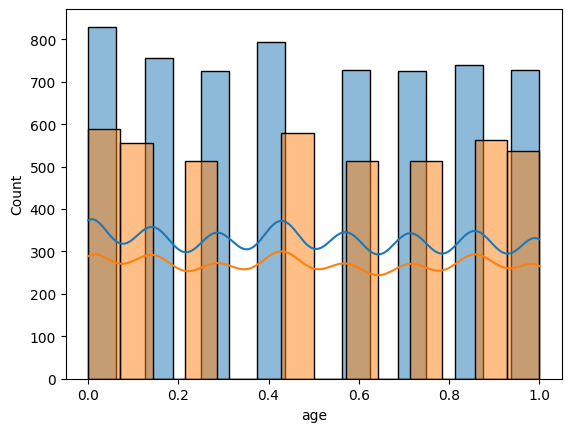

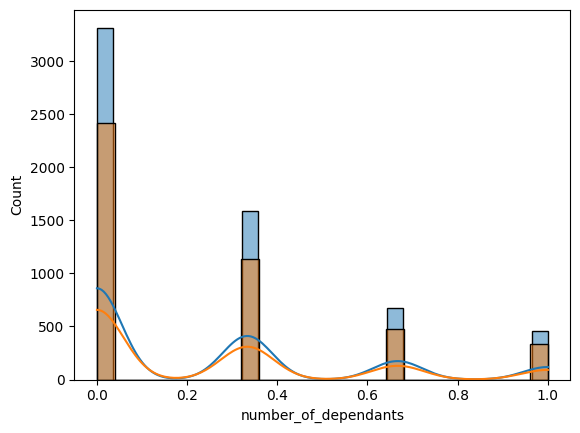

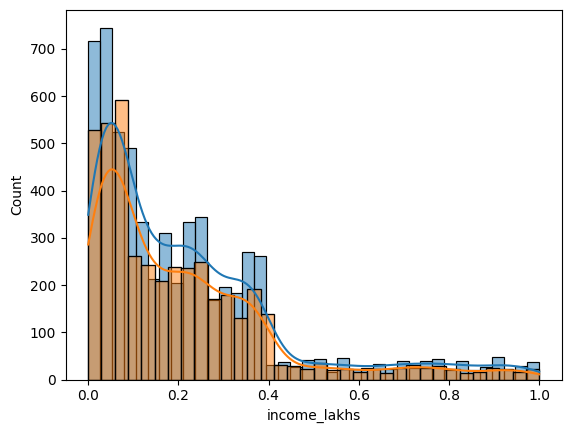

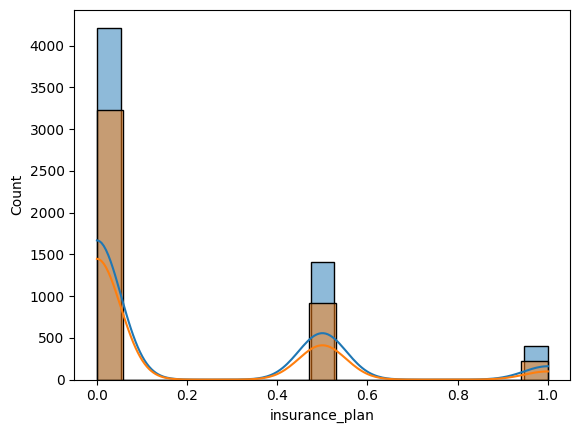

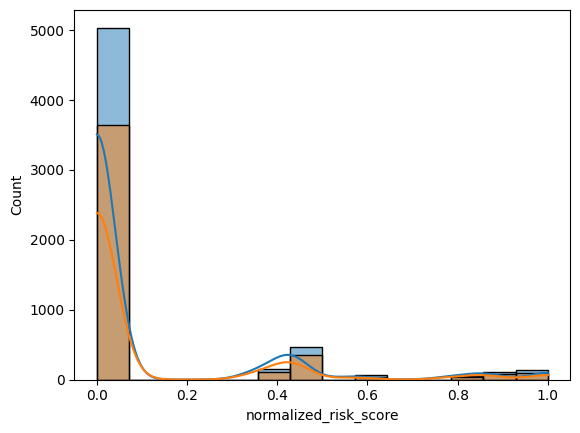

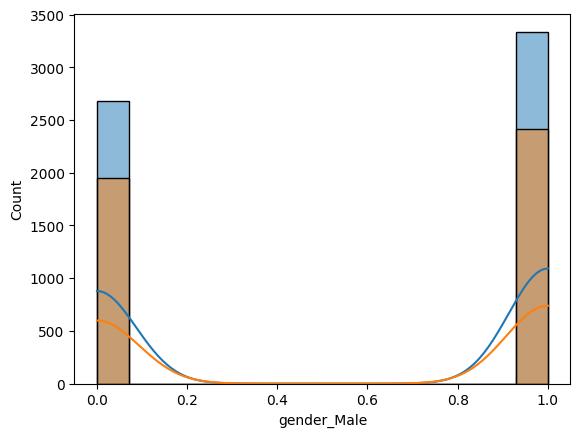

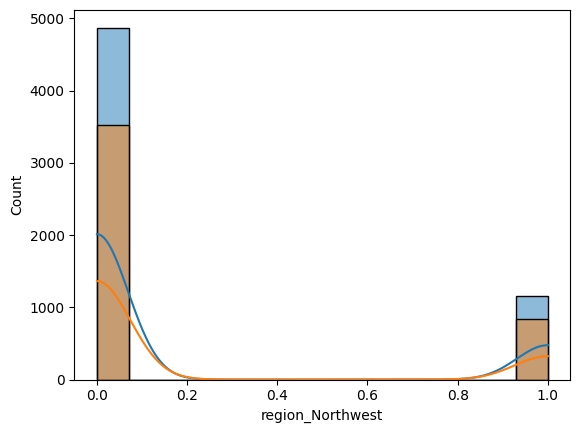

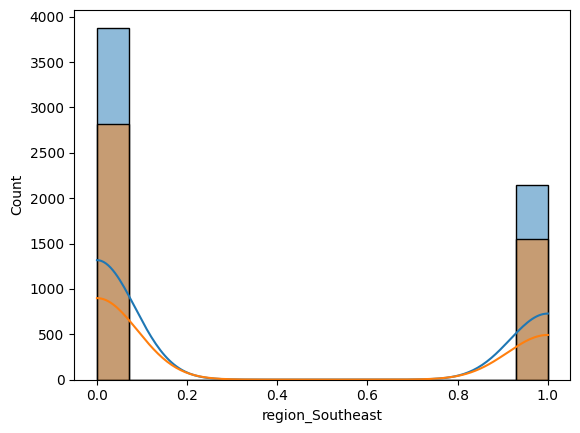

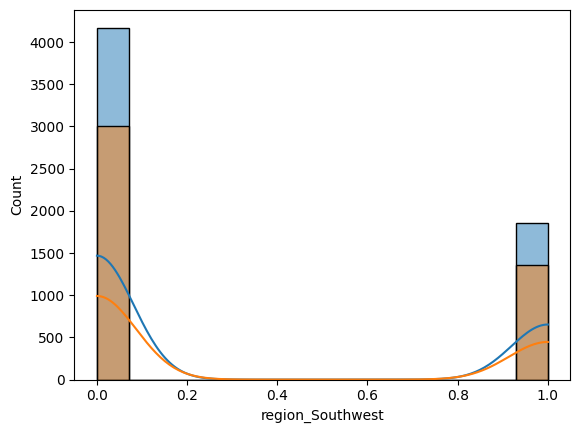

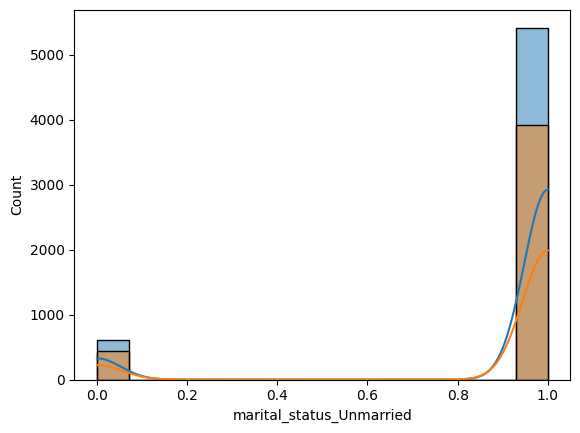

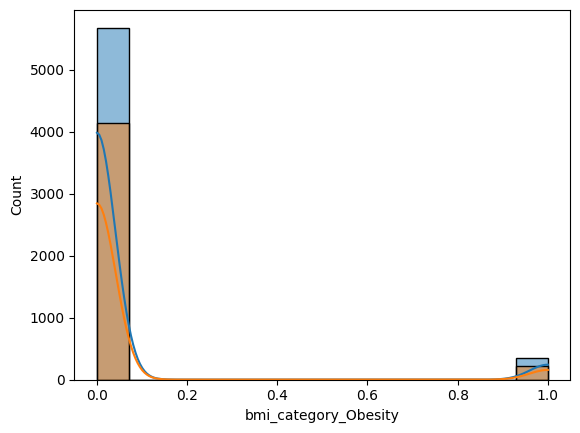

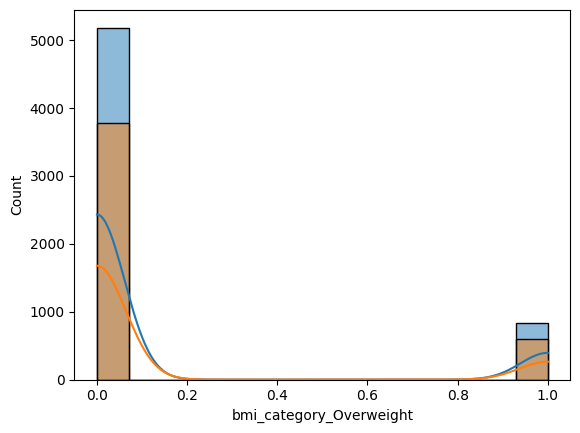

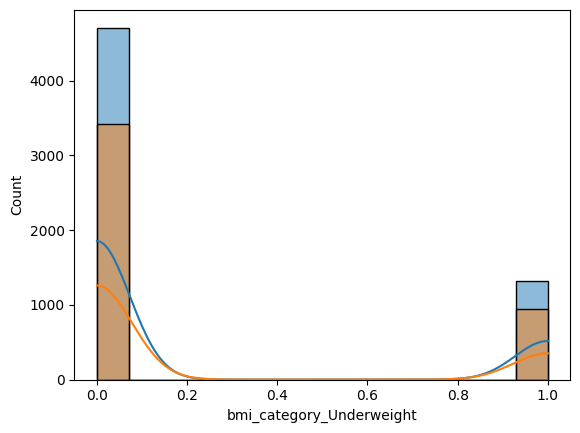

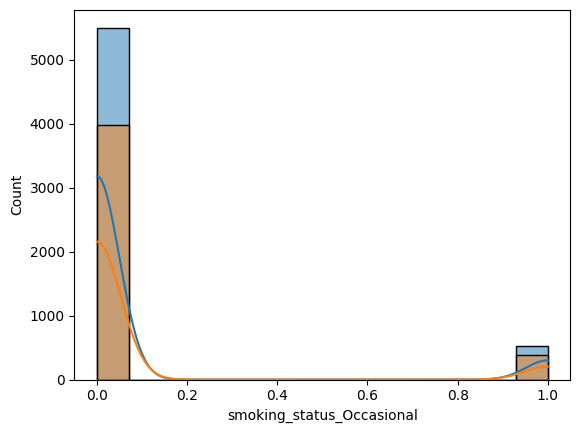

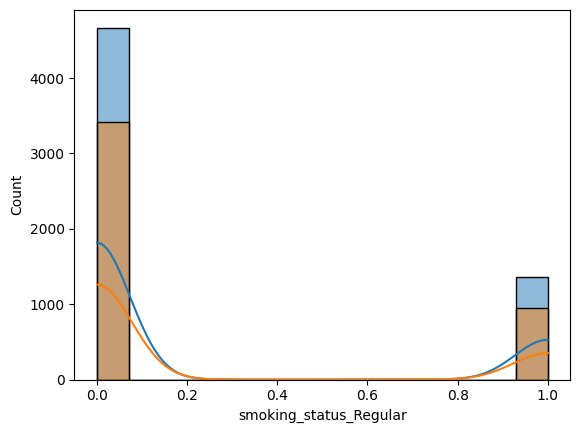

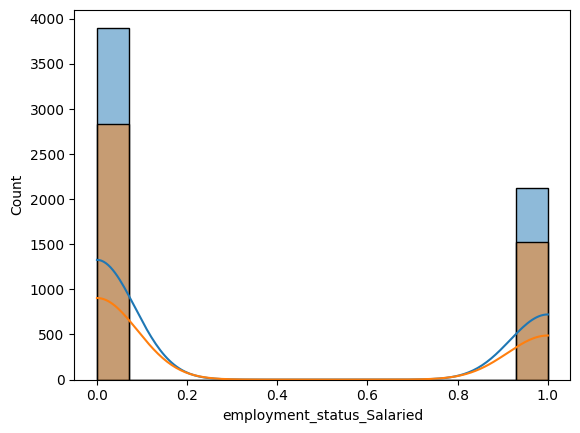

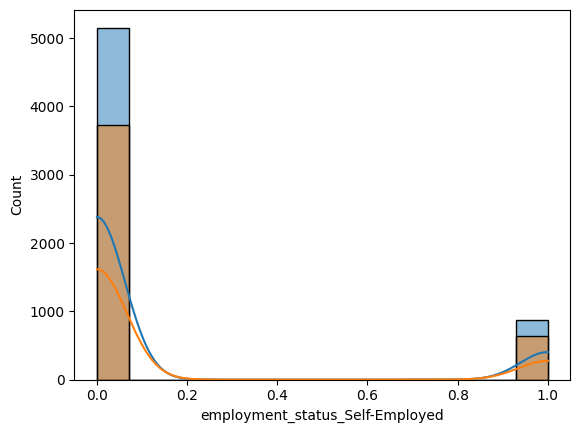

In [53]:
# Plotting histplot for all fetures
for featuree in X_test.columns:
    sns.histplot(X_test[featuree], kde=True)
    sns.histplot(extreme_error_df[featuree], kde=True)
    plt.show()

In [54]:
# Seems like age column has something fishy
extreme_error_df['income_level'] = -1
reversed_scaling = pd.DataFrame()
reversed_scaling[cols_to_scale] = scaler.inverse_transform(extreme_error_df[cols_to_scale])
reversed_scaling['age'].quantile(0.98) # Almost 98 percent of population in extreme error df is 25 years of age or less

25.0